# 第1次讀書會：對ptt機車、車、汽車買賣版「電動、燃油」車進行情緒分析-1
**組別:** 第二組<br>
**組員:** 李昌澤、林咨妤、毛天楷、林冠杰、劉捷生、張家馨、蔡尚宸<br>

## 大綱
+ 1. import套件
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒詞彙頻率折線圖圖
    + 3.4 正負向情緒詞彙比例折線圖圖
    + 3.5 正負向情緒分數折線圖圖
    + 3.6 文章為單位的情緒分析
    + 3.7 情緒代表字
    + 3.8 文字雲
+ <b>我們的發現</b>

## 1. import 套件

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

In [2]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 2. 資料前處理
使用「電車、電動車、油車」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 2.1 基本資料
- 資料來源: 工作流程蒐集PTT 機車、車、汽車買賣版 2021-03-17 ~ 2024-3-17 所有文章

In [3]:
df = pd.read_csv("sna2024s_2_f85d64175d_4.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,bearboss,biker,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""joechen39"", ...",59.126.87.133,2021-03-18 00:06:26,ptt
1,2,https://www.ptt.cc/bbs/biker/M.1616037467.A.CA...,[問題]GOGORO改裝+魚眼大燈,2021-03-18,Pepepigs830,biker,弟弟去年底跟媽媽要了一台GGR S2 ABS\n最近開始觀望要來個大改造\n他一直在研究魚眼...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""stillcolor"",...",39.12.32.166,2021-03-20 00:09:19,ptt
2,3,https://www.ptt.cc/bbs/biker/M.1616059525.A.BB...,[閒聊]有人知道這是哪牌的機車嗎？,2021-03-18,happy2gether,biker,今天在內湖公司附近看到的電動車，很驚訝現在電動機車有做成重機的樣子！動力應該是用座墊下面的長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""elynn889"", ""...",1.200.10.142,2021-03-20 00:09:24,ptt
3,4,https://www.ptt.cc/bbs/biker/M.1616069055.A.FC...,[閒聊]光陽模仿gogoro能賺錢嗎?,2021-03-18,yuuuuu,biker,就在今日光陽發表了跟gogoro有8成7相似的東西\n\n車子、電池、換電櫃、月租 概念都...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""misu2718"", ""...",111.250.90.9,2021-03-20 00:09:24,ptt
4,5,https://www.ptt.cc/bbs/biker/M.1616074981.A.4D...,[新聞]Kymcoionex3.0，四款白牌純電雙輪發表,2021-03-18,clazziquai,biker,原文連結:\nhttps://pse.is/3bgnqb\n原文內容:\n如同過去知名的古龍...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""yulbin98"", ""...",118.167.243.98,2021-03-20 00:09:24,ptt


### 2.2資料清理

In [4]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,《是否已閱讀置底文章『[新車] 2012主流車種比較』》。 沒看見2021主流車種耶.....
1,https://www.ptt.cc/bbs/biker/M.1616037467.A.CA...,[問題]GOGORO改裝+魚眼大燈,2021-03-18,弟弟去年底跟媽媽要了一台GGR S2 ABS\n最近開始觀望要來個大改造\n他一直在研究魚眼...,弟弟去年底跟媽媽要了一台GGR S2 ABS最近開始觀望要來個大改造他一直在研究魚眼大燈和前...
2,https://www.ptt.cc/bbs/biker/M.1616059525.A.BB...,[閒聊]有人知道這是哪牌的機車嗎？,2021-03-18,今天在內湖公司附近看到的電動車，很驚訝現在電動機車有做成重機的樣子！動力應該是用座墊下面的長...,今天在內湖公司附近看到的電動車，很驚訝現在電動機車有做成重機的樣子！動力應該是用座墊下面的長...
3,https://www.ptt.cc/bbs/biker/M.1616069055.A.FC...,[閒聊]光陽模仿gogoro能賺錢嗎?,2021-03-18,就在今日光陽發表了跟gogoro有8成7相似的東西\n\n車子、電池、換電櫃、月租 概念都...,就在今日光陽發表了跟gogoro有8成7相似的東西。車子、電池、換電櫃、月租 概念都很類似...
4,https://www.ptt.cc/bbs/biker/M.1616074981.A.4D...,[新聞]Kymcoionex3.0，四款白牌純電雙輪發表,2021-03-18,原文連結:\nhttps://pse.is/3bgnqb\n原文內容:\n如同過去知名的古龍...,原文連結: ionex 3.0亦開發出3款外型近似但性能有著顯著區別的雙電池座駕S6、S7以...
...,...,...,...,...,...
6167,https://www.ptt.cc/bbs/CarShop/M.1709966268.A....,[售車]新竹FIT油電車2022/白白/里程43000,2024-03-09,車輛品牌/產地/出廠年月： 2023/3\n\n車款型式/排氣量：1500\n\n顏色/排檔...,車輛品牌/產地/出廠年月： 2023/3。車款型式/排氣量：1500。顏色/排檔形式：白車 ...
6168,https://www.ptt.cc/bbs/CarShop/M.1710263227.A....,[售車]2013FordFocus4D1.6豪華型,2024-03-13,車輛品牌/產地/出廠年月：Ford／2012年11月\n\n車款型式/排氣量：Ford Fo...,車輛品牌/產地/出廠年月：Ford／2012年11月。車款型式/排氣量：Ford Focus...
6169,https://www.ptt.cc/bbs/CarShop/M.1710347967.A....,[售車]PorscheTaycan轉單,2024-03-14,車輛品牌/產地/出廠年月：保時捷/德國/2024年1月\n\n車款型式：Taycan\n\n...,車輛品牌/產地/出廠年月：保時捷/德國/2024年1月。車款型式：Taycan。顏色：白色電...
6170,https://www.ptt.cc/bbs/CarShop/M.1710431817.A....,[售車]2015BMW318dF30B47引擎,2024-03-14,車輛品牌/產地/出廠年月：BMW / 2015年09出廠 (2016式小改款B47引擎) 2...,車輛品牌/產地/出廠年月：BMW / 2015年09出廠 (2016式小改款B47引擎) 2...


斷句及分類電動車、燃油車

In [5]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)
# 分電動/油車
electric_keywords = ['電動車', '特斯拉', '電動汽車', '電動機車', '電車', '充電']
fuel_keywords = ['燃油車', '油車', '燃油', '加油']

# 標註文本
def label_text(row):
    if any(keyword in row['sentence'] for keyword in electric_keywords):
        return '電動車'
    elif any(keyword in row['sentence'] for keyword in fuel_keywords):
        return '燃油車'
    else:
        return 'both'

sent_df['category'] = sent_df.apply(label_text, axis=1)
sent_df

,artUrl,artTitle,artDate,artContent,sentence,category
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,《是否已閱讀置底文章『[新車] 2012主流車種比較』》,both
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,沒看見2021主流車種耶....,both
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,《是否至車行看過實車》,both
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,只有試騎Gogoro S2 PLUS S3,both
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,《欲比較之品牌及車種》,both
...,...,...,...,...,...,...
169320,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,二手車使用5年 當初貸款購買 已經結清,both
169321,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,有問過還可以貸款,both
169322,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,可以試乘 可以配合檢查,both
169323,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,龍潭附近的區域都可以看車 不要跑太遠就好,both


In [6]:
sent_df[sent_df['category'] == '電動車']

,artUrl,artTitle,artDate,artContent,sentence,category
5,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,油車無品牌偏好 但聽說電動車就是要Gogoro,電動車
11,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,但是「我真的真的很喜歡電動車的加速力跟CBS煞車(試騎時只有這種)」,電動車
15,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,只是沒有電動車那麼快 但是很明顯的是置物空間大不少（這是我這個新手唯一真正看懂的最大差異 X...,電動車
22,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,3.我把精華區新手介紹大略的看過一遍 卻沒看到電動車的介紹當然更沒有電動車跟油車的比較....,電動車
24,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,5.請問養油車跟養電動車 那個比較便宜,電動車
...,...,...,...,...,...,...
169190,https://www.ptt.cc/bbs/CarShop/M.1709363046.A....,[售車]台中2024Porschetaycan,2024-03-02,車輛品牌/產地/出廠年月： 2024年1月\n\n車款型式/排氣量：taycan\n\n顏色...,000) 及 家用充電座(價值110,電動車
169205,https://www.ptt.cc/bbs/CarShop/M.1709618759.A....,[售車]2021FordKugaST-LineX,2024-03-05,車輛品牌/產地/出廠年月：Ford/國產/2021年9月\n\n車款型式/排氣量：Ford ...,原廠加值型保固至2027/9高速公路通勤車（90%高速）里程100xxx 要換電動車 純自...,電動車
169217,https://www.ptt.cc/bbs/CarShop/M.1709738464.A....,[售車][台中]20192.0CX-5星燦藍旗艦版,2024-03-06,車輛品牌/產地/出廠年月： Mazda/日本/2019年03月\n\n車款型式/排氣量：CX...,◇ 因換電車,電動車
169267,https://www.ptt.cc/bbs/CarShop/M.1710263227.A....,[售車]2013FordFocus4D1.6豪華型,2024-03-13,車輛品牌/產地/出廠年月：Ford／2012年11月\n\n車款型式/排氣量：Ford Fo...,有裝安卓多媒體機5. 新換電動車故出售,電動車


In [7]:
sent_df[sent_df['category'] == '燃油車']

,artUrl,artTitle,artDate,artContent,sentence,category
14,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,然後是150CC的油車 我只騎過兩三次 它一樣可以做到上陂持續加速,燃油車
29,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,6.買油車的話 有認識的車行 老闆人很實在 但Gogoro價錢好像都是公定價了(,燃油車
40,https://www.ptt.cc/bbs/biker/M.1616037467.A.CA...,[問題]GOGORO改裝+魚眼大燈,2021-03-18,弟弟去年底跟媽媽要了一台GGR S2 ABS\n最近開始觀望要來個大改造\n他一直在研究魚眼...,另外 因為版上看到改裝魚眼大燈的大多是油車目前有看到APL阿波羅的魚眼大燈很不錯 也有裝GO...,燃油車
62,https://www.ptt.cc/bbs/biker/M.1616074981.A.4D...,[新聞]Kymcoionex3.0，四款白牌純電雙輪發表,2021-03-18,原文連結:\nhttps://pse.is/3bgnqb\n原文內容:\n如同過去知名的古龍...,造型不禁令人想起系出同門的燃油機車Racing系列,燃油車
162,https://www.ptt.cc/bbs/biker/M.1616427772.A.EB...,Re:[閒聊]閃過違停之後還會切回原車道嗎?,2021-03-22,如果你能跟上車流，\n並且這個車流是你熟悉的速度，\n也不是臭臭的柴油車、卡位的公車，\n就...,也不是臭臭的柴油車、卡位的公車,燃油車
...,...,...,...,...,...,...
169004,https://www.ptt.cc/bbs/CarShop/M.1706184030.A....,[購車]RAV4油車旗艦,2024-01-25,車輛狀況：全新\n車輛品牌：Toyota\n車款型式：RAV4油車旗艦 ，領牌車也ok\n車...,車輛狀況：全新車輛品牌：Toyota車款型式：RAV4油車旗艦,燃油車
169046,https://www.ptt.cc/bbs/CarShop/M.1708149690.A....,[售車]2012ToyotaCamry2.0,2024-02-17,"車輛品牌/產地/出廠年月： 2012年O1月\n\n車款型式/排氣量：油車,型式:ACV51...",車款型式/排氣量：油車,燃油車
169238,https://www.ptt.cc/bbs/CarShop/M.1709913747.A....,[售車]售2007HyundaiTucsonVgt2.0L,2024-03-09,車輛品牌/產地/出廠年月：Hyundai Tucson 2007年12月\n\n車款型式/排...,2.0柴油車燃料稅3,燃油車
169284,https://www.ptt.cc/bbs/CarShop/M.1710431817.A....,[售車]2015BMW318dF30B47引擎,2024-03-14,車輛品牌/產地/出廠年月：BMW / 2015年09出廠 (2016式小改款B47引擎) 2...,沒有開過柴油車的朋友可以體驗看看只有在高速公路才會切換到sport模式,燃油車


In [8]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from d:\研究所\碩一\112-2\社群媒體分析\code\socialMedia_practice\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.ufde21439e166f0d430de72e3ec6e76af.cache
Loading model cost 0.710 seconds.
Prefix dict has been built successfully.


In [9]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artUrl,artTitle,artDate,artContent,sentence,category
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,是否已閱讀置底文章新車 2012主流車種比較,both
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,沒看見2021主流車種耶,both
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,是否至車行看過實車,both
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,只有試騎Gogoro S2 PLUS S3,both
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,欲比較之品牌及車種,both
...,...,...,...,...,...,...
169320,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,二手車使用5年 當初貸款購買 已經結清,both
169321,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,有問過還可以貸款,both
169322,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,可以試乘 可以配合檢查,both
169323,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,龍潭附近的區域都可以看車 不要跑太遠就好,both


### 2.3 文章斷詞

In [10]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

,artUrl,artTitle,artDate,artContent,category,word
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,是否
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,閱讀
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,置底
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,文章
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,2012
...,...,...,...,...,...,...
169323,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,太遠
169324,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,40
169324,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,稅金
169324,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,攤分


移除停用字<br>
我們將以下停用字加入到stopword.txt中
「電動車、汽車、原文、一下、現在、一台、目前、看到、連結、知道、部分、感覺、需要、內容、表示、推出、
使用、不用、未來、銷售、提供、直接、今年、完全、考慮、發展、一直、電動、這種、進行、全新、希望、主要、控制、重要、朋友」

In [11]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

In [12]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,category,word
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,閱讀
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,置底
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,文章
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,2012
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,both,主流
...,...,...,...,...,...,...
169323,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,看車
169323,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,太遠
169324,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,40
169324,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,[售車]2014年10月出廠BMW218D2.0L,2024-03-15,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,both,稅金


## 3. Lexicon-based 情緒分析

### 3.1 準備LIWC字典  

In [13]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [14]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [15]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word", 'category']], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,category,sentiments
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,閱讀,both,NaN
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,置底,both,NaN
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,文章,both,NaN
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,2012,both,NaN
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,主流,both,NaN
...,...,...,...,...,...,...,...
847552,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,2024-03-15,[售車]2014年10月出廠BMW218D2.0L,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,看車,both,NaN
847553,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,2024-03-15,[售車]2014年10月出廠BMW218D2.0L,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,太遠,both,NaN
847554,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,2024-03-15,[售車]2014年10月出廠BMW218D2.0L,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,40,both,NaN
847555,https://www.ptt.cc/bbs/CarShop/M.1710473402.A....,2024-03-15,[售車]2014年10月出廠BMW218D2.0L,車輛品牌/產地/出廠年月： BMW/德國/2014.10出廠、2015.01領牌\n\n車款...,稅金,both,NaN


### 3.3 正負向情緒詞彙頻率折線圖圖
文集中，正向（positive）與負向（negative）情緒的折線圖

In [16]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments", "category"]).size()
).reset_index()

mask = ((sentiment_count['sentiments'] == "positive") | 
        (sentiment_count['sentiments'] == "negative")) & \
       (sentiment_count['category'].isin(['電動車', '燃油車']))
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,category,size
5,2021-03-17,positive,電動車,3
12,2021-03-18,negative,燃油車,1
13,2021-03-18,negative,電動車,5
15,2021-03-18,positive,燃油車,1
16,2021-03-18,positive,電動車,7
...,...,...,...,...
9077,2024-03-14,positive,電動車,2
9082,2024-03-15,negative,電動車,2
9084,2024-03-15,positive,電動車,2
9093,2024-03-16,negative,燃油車,2


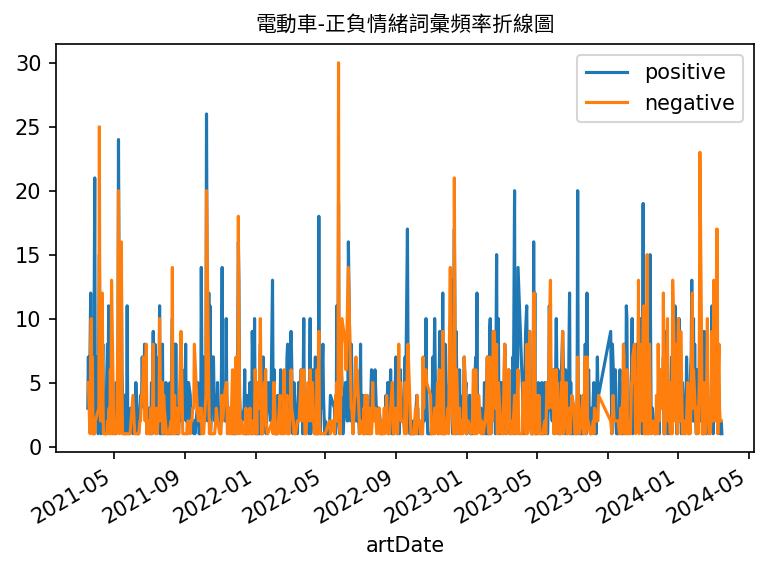

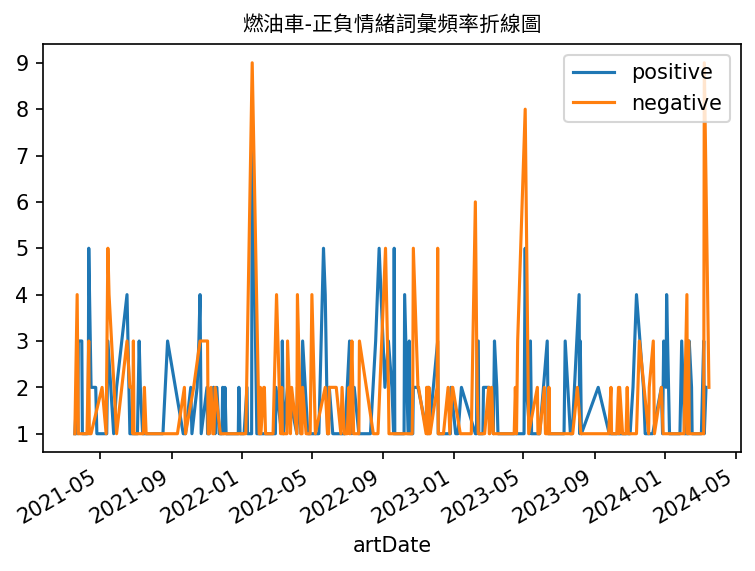

In [17]:
colors = ["tab:blue", "tab:orange"]
ele_pos = sentiment_count[(sentiment_count["sentiments"] == "positive") & (sentiment_count["category"] == '電動車')]
ele_neg = sentiment_count[(sentiment_count["sentiments"] == "negative") & (sentiment_count["category"] == '電動車')]
fuel_pos = sentiment_count[(sentiment_count["sentiments"] == "positive") & (sentiment_count["category"] == '燃油車')]
fuel_neg = sentiment_count[(sentiment_count["sentiments"] == "negative") & (sentiment_count["category"] == '燃油車')]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(ele_pos["artDate"], ele_pos["size"], color=colors[0])
ax.plot(ele_neg["artDate"], ele_neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("電動車-正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(fuel_pos["artDate"], fuel_pos["size"], color=colors[0])
ax.plot(fuel_neg["artDate"], fuel_neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("燃油車-正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

#### 進行rolling average，去除數據中的噪音，rolling day = 14，去看長期的情緒趨勢，減少短期波動干擾。

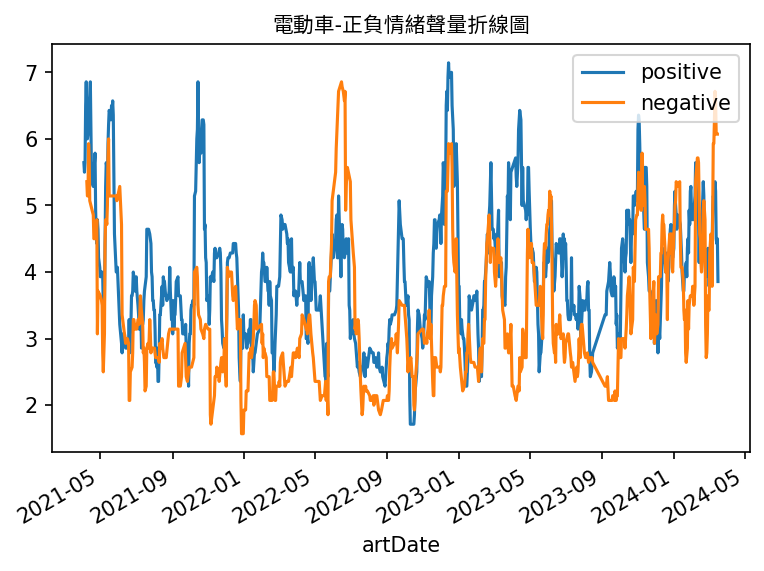

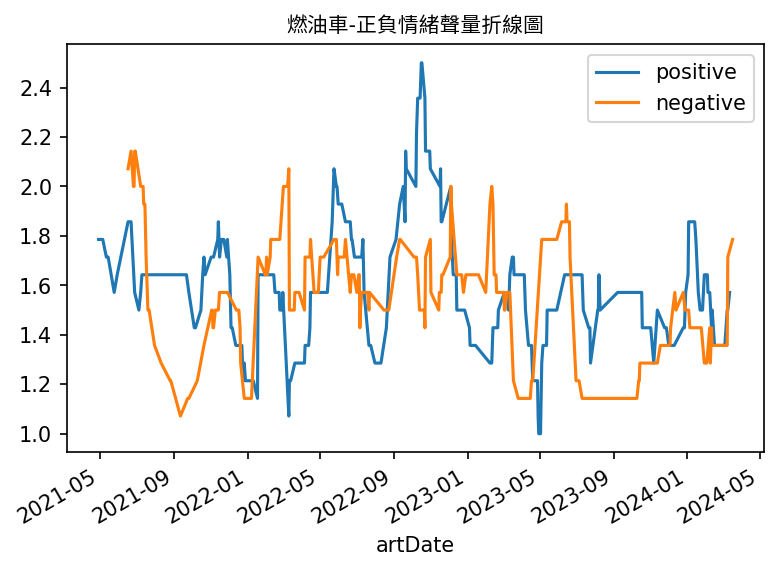

In [18]:
colors = ["tab:blue", "tab:orange"]
ele_pos = sentiment_count[(sentiment_count["sentiments"] == "positive") & (sentiment_count["category"] == '電動車')]
ele_neg = sentiment_count[(sentiment_count["sentiments"] == "negative") & (sentiment_count["category"] == '電動車')]
fuel_pos = sentiment_count[(sentiment_count["sentiments"] == "positive") & (sentiment_count["category"] == '燃油車')]
fuel_neg = sentiment_count[(sentiment_count["sentiments"] == "negative") & (sentiment_count["category"] == '燃油車')]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(ele_pos["artDate"], ele_pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(ele_neg["artDate"], ele_neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("電動車-正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(fuel_pos["artDate"], fuel_pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(fuel_neg["artDate"], fuel_neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("燃油車-正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正負面的詞出現頻率差異不大，尤其是在電動車。燃油車的部分，可以看到偶爾有段時間正面高於負面。

### 3.4 正負向情緒詞彙比例折線圖圖

In [19]:
# sentiment_count = sentiment_count.assign(
#     ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
# )
# sentiment_count

electric_sentiment_count = sentiment_count[sentiment_count['category'] == '電動車']
fuel_sentiment_count = sentiment_count[sentiment_count['category'] == '燃油車']

electric_sentiment_count = electric_sentiment_count.assign(
    ratio=electric_sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

fuel_sentiment_count = fuel_sentiment_count.assign(
    ratio=fuel_sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

electric_sentiment_count


,artDate,sentiments,category,size,ratio
5,2021-03-17,positive,電動車,3,1.000000
13,2021-03-18,negative,電動車,5,0.416667
16,2021-03-18,positive,電動車,7,0.583333
23,2021-03-19,positive,電動車,3,1.000000
30,2021-03-20,negative,電動車,2,0.333333
...,...,...,...,...,...
9070,2024-03-13,positive,電動車,1,0.333333
9077,2024-03-14,positive,電動車,2,1.000000
9082,2024-03-15,negative,電動車,2,0.500000
9084,2024-03-15,positive,電動車,2,0.500000


In [20]:
fuel_sentiment_count

,artDate,sentiments,category,size,ratio
12,2021-03-18,negative,燃油車,1,0.500000
15,2021-03-18,positive,燃油車,1,0.500000
44,2021-03-22,negative,燃油車,4,0.666667
47,2021-03-22,positive,燃油車,2,0.333333
60,2021-03-23,positive,燃油車,1,1.000000
...,...,...,...,...,...
8997,2024-03-07,positive,燃油車,3,0.750000
9011,2024-03-08,negative,燃油車,9,0.900000
9014,2024-03-08,positive,燃油車,1,0.100000
9047,2024-03-11,positive,燃油車,2,1.000000


In [21]:
pos = electric_sentiment_count[electric_sentiment_count["sentiments"] == "positive"]
neg = electric_sentiment_count[electric_sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '電動車-正負情緒比例折線圖')

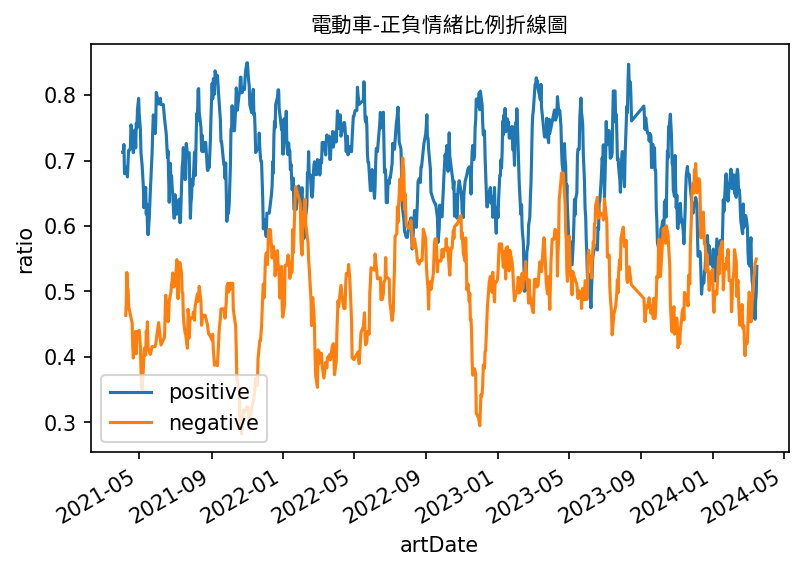

In [22]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("電動車-正負情緒比例折線圖", fontproperties=fprop)

In [23]:
pos = fuel_sentiment_count[fuel_sentiment_count["sentiments"] == "positive"]
neg = fuel_sentiment_count[fuel_sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '燃油車-正負情緒比例折線圖')

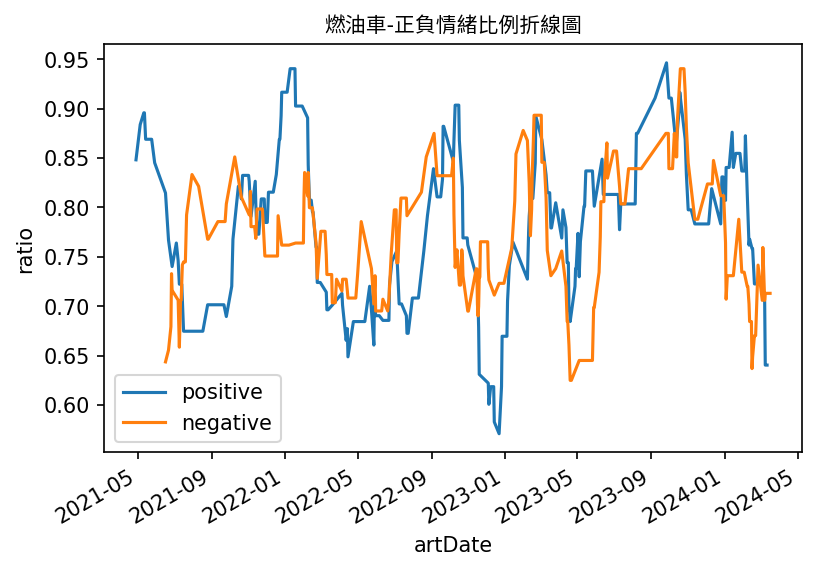

In [24]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("燃油車-正負情緒比例折線圖", fontproperties=fprop)

### 3.5 正負向情緒分數折線圖

In [25]:
electric_sentiment_count

,artDate,sentiments,category,size,ratio
5,2021-03-17,positive,電動車,3,1.000000
13,2021-03-18,negative,電動車,5,0.416667
16,2021-03-18,positive,電動車,7,0.583333
23,2021-03-19,positive,電動車,3,1.000000
30,2021-03-20,negative,電動車,2,0.333333
...,...,...,...,...,...
9070,2024-03-13,positive,電動車,1,0.333333
9077,2024-03-14,positive,電動車,2,1.000000
9082,2024-03-15,negative,電動車,2,0.500000
9084,2024-03-15,positive,電動車,2,0.500000


In [26]:
fuel_sentiment_count

,artDate,sentiments,category,size,ratio
12,2021-03-18,negative,燃油車,1,0.500000
15,2021-03-18,positive,燃油車,1,0.500000
44,2021-03-22,negative,燃油車,4,0.666667
47,2021-03-22,positive,燃油車,2,0.333333
60,2021-03-23,positive,燃油車,1,1.000000
...,...,...,...,...,...
8997,2024-03-07,positive,燃油車,3,0.750000
9011,2024-03-08,negative,燃油車,9,0.900000
9014,2024-03-08,positive,燃油車,1,0.100000
9047,2024-03-11,positive,燃油車,2,1.000000


### 電動車的

In [27]:
ptt_sentiment_value = (
    electric_sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2021-03-17,0.0,3.0
1,2021-03-18,5.0,7.0
2,2021-03-19,0.0,3.0
3,2021-03-20,2.0,4.0
4,2021-03-21,1.0,0.0


In [28]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2021-03-17,0.0,3.0,3.0
1,2021-03-18,5.0,7.0,2.0
2,2021-03-19,0.0,3.0,3.0
3,2021-03-20,2.0,4.0,2.0
4,2021-03-21,1.0,0.0,-1.0


Text(0.5, 1.0, '電動車-正負情緒分數趨勢折線圖')

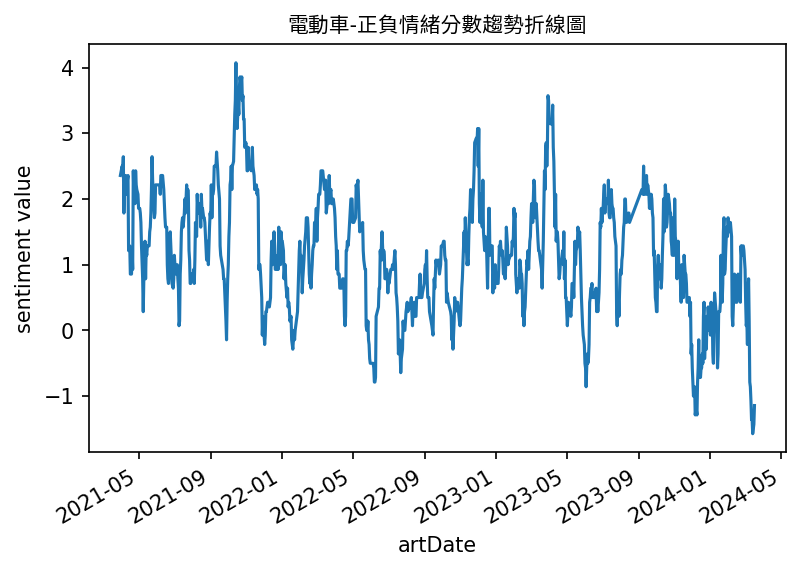

In [29]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("電動車-正負情緒分數趨勢折線圖", fontproperties=fprop)

### 燃油車的

In [30]:
ptt_sentiment_value = (
    fuel_sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2021-03-18,1.0,1.0
1,2021-03-22,4.0,2.0
2,2021-03-23,0.0,1.0
3,2021-03-24,1.0,3.0
4,2021-03-29,1.0,0.0


In [31]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2021-03-18,1.0,1.0,0.0
1,2021-03-22,4.0,2.0,-2.0
2,2021-03-23,0.0,1.0,1.0
3,2021-03-24,1.0,3.0,2.0
4,2021-03-29,1.0,0.0,-1.0


Text(0.5, 1.0, '燃油車-正負情緒分數趨勢折線圖')

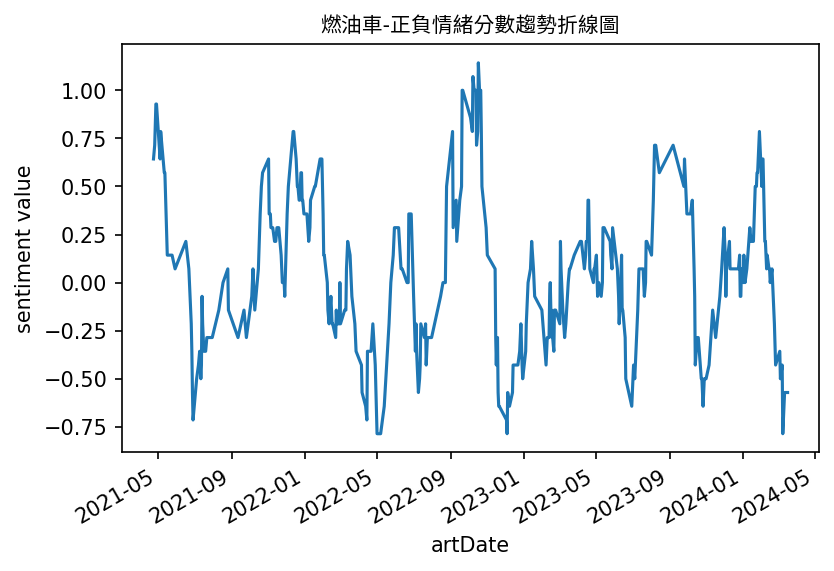

In [32]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("燃油車-正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.6 文章為單位的情緒分析

#### 先拆成電動車跟燃油車

In [33]:
electric_articles = ptt_liwc_df[ptt_liwc_df['category'] == '電動車']
fuel_articles = ptt_liwc_df[ptt_liwc_df['category'] == '燃油車']

電動車

In [34]:
electric_sentiment_count_by_article = pd.DataFrame(
    electric_articles.groupby(["artUrl", "sentiments"]).size()
).reset_index().rename(columns={0: "size"})

electric_sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/CarShop/M.1616386218.A....,affect,14
1,https://www.ptt.cc/bbs/CarShop/M.1616386218.A....,anx,1
2,https://www.ptt.cc/bbs/CarShop/M.1616386218.A....,negative,6
3,https://www.ptt.cc/bbs/CarShop/M.1616386218.A....,positive,7
4,https://www.ptt.cc/bbs/CarShop/M.1618833039.A....,affect,2
...,...,...,...
6043,https://www.ptt.cc/bbs/car/M.1710489944.A.1DC....,negative,2
6044,https://www.ptt.cc/bbs/car/M.1710489944.A.1DC....,positive,2
6045,https://www.ptt.cc/bbs/car/M.1710489944.A.1DC....,sad,1
6046,https://www.ptt.cc/bbs/car/M.1710560484.A.681....,affect,1


In [35]:
ptt_sentiment_value_by_article = (
    electric_sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/CarShop/M.1616386218.A....,14.0,0.0,1.0,6.0,7.0,0.0
1,https://www.ptt.cc/bbs/CarShop/M.1618833039.A....,2.0,0.0,0.0,0.0,2.0,0.0
2,https://www.ptt.cc/bbs/CarShop/M.1626135336.A....,2.0,0.0,0.0,0.0,2.0,0.0
3,https://www.ptt.cc/bbs/CarShop/M.1627196630.A....,2.0,0.0,0.0,1.0,1.0,0.0
4,https://www.ptt.cc/bbs/CarShop/M.1630413928.A....,2.0,0.0,0.0,0.0,2.0,0.0


In [36]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/CarShop/M.1616386218.A....,14.0,0.0,1.0,6.0,7.0,0.0,1.0
1,https://www.ptt.cc/bbs/CarShop/M.1618833039.A....,2.0,0.0,0.0,0.0,2.0,0.0,2.0
2,https://www.ptt.cc/bbs/CarShop/M.1626135336.A....,2.0,0.0,0.0,0.0,2.0,0.0,2.0
3,https://www.ptt.cc/bbs/CarShop/M.1627196630.A....,2.0,0.0,0.0,1.0,1.0,0.0,0.0
4,https://www.ptt.cc/bbs/CarShop/M.1630413928.A....,2.0,0.0,0.0,0.0,2.0,0.0,2.0


In [37]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/CarShop/M.1616386218.A....,14.0,0.0,1.0,6.0,7.0,0.0,1.0,正向
1,https://www.ptt.cc/bbs/CarShop/M.1618833039.A....,2.0,0.0,0.0,0.0,2.0,0.0,2.0,正向
2,https://www.ptt.cc/bbs/CarShop/M.1626135336.A....,2.0,0.0,0.0,0.0,2.0,0.0,2.0,正向
3,https://www.ptt.cc/bbs/CarShop/M.1627196630.A....,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
4,https://www.ptt.cc/bbs/CarShop/M.1630413928.A....,2.0,0.0,0.0,0.0,2.0,0.0,2.0,正向


In [38]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,bearboss,biker,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""joechen39"", ...",59.126.87.133,2021-03-18 00:06:26,ptt,正向
1,2,https://www.ptt.cc/bbs/biker/M.1616037467.A.CA...,[問題]GOGORO改裝+魚眼大燈,2021-03-18,Pepepigs830,biker,弟弟去年底跟媽媽要了一台GGR S2 ABS\n最近開始觀望要來個大改造\n他一直在研究魚眼...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""stillcolor"",...",39.12.32.166,2021-03-20 00:09:19,ptt,NaN
2,3,https://www.ptt.cc/bbs/biker/M.1616059525.A.BB...,[閒聊]有人知道這是哪牌的機車嗎？,2021-03-18,happy2gether,biker,今天在內湖公司附近看到的電動車，很驚訝現在電動機車有做成重機的樣子！動力應該是用座墊下面的長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""elynn889"", ""...",1.200.10.142,2021-03-20 00:09:24,ptt,負向
3,4,https://www.ptt.cc/bbs/biker/M.1616069055.A.FC...,[閒聊]光陽模仿gogoro能賺錢嗎?,2021-03-18,yuuuuu,biker,就在今日光陽發表了跟gogoro有8成7相似的東西\n\n車子、電池、換電櫃、月租 概念都...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""misu2718"", ""...",111.250.90.9,2021-03-20 00:09:24,ptt,NaN
4,5,https://www.ptt.cc/bbs/biker/M.1616074981.A.4D...,[新聞]Kymcoionex3.0，四款白牌純電雙輪發表,2021-03-18,clazziquai,biker,原文連結:\nhttps://pse.is/3bgnqb\n原文內容:\n如同過去知名的古龍...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""yulbin98"", ""...",118.167.243.98,2021-03-20 00:09:24,ptt,NaN


In [39]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2021-03-17,正向,2
1,2021-03-18,正向,1
2,2021-03-18,負向,2
3,2021-03-19,正向,1
4,2021-03-20,正向,1
...,...,...,...
1302,2024-03-13,正向,1
1303,2024-03-13,負向,1
1304,2024-03-14,正向,1
1305,2024-03-15,負向,1


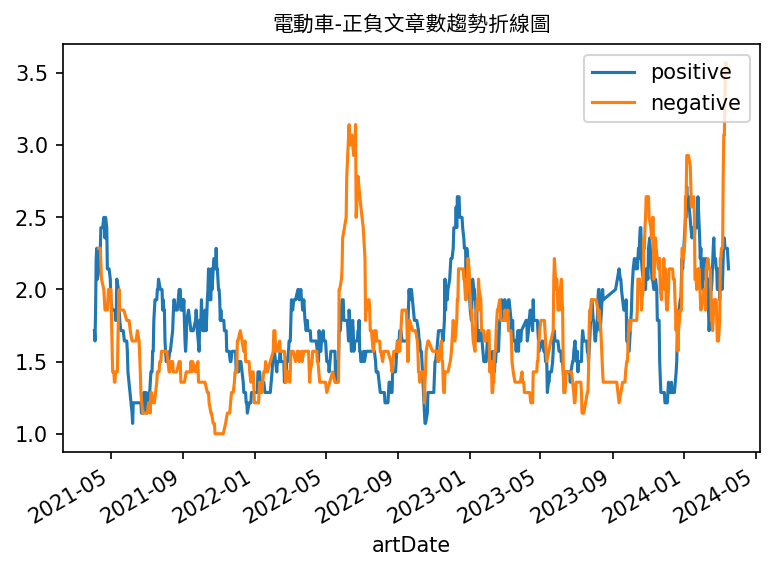

In [40]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("電動車-正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

文章都有被歸類在正負向文章，討論電動車的正負向情緒都有。

燃油車

In [41]:
fuel_sentiment_count_by_article = pd.DataFrame(
    fuel_articles.groupby(["artUrl", "sentiments"]).size()
).reset_index().rename(columns={0: "size"})

fuel_sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/CarShop/M.1624804989.A....,affect,1
1,https://www.ptt.cc/bbs/CarShop/M.1624804989.A....,positive,1
2,https://www.ptt.cc/bbs/CarShop/M.1635760135.A....,affect,3
3,https://www.ptt.cc/bbs/CarShop/M.1635760135.A....,positive,2
4,https://www.ptt.cc/bbs/CarShop/M.1636732880.A....,affect,3
...,...,...,...
1211,https://www.ptt.cc/bbs/car/M.1710146925.A.EA1....,positive,1
1212,https://www.ptt.cc/bbs/car/M.1710263510.A.CD1....,affect,1
1213,https://www.ptt.cc/bbs/car/M.1710518971.A.6FF....,affect,1
1214,https://www.ptt.cc/bbs/car/M.1710518971.A.6FF....,anger,1


In [42]:
ptt_sentiment_value_by_article = (
    fuel_sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/CarShop/M.1624804989.A....,1.0,0.0,0.0,0.0,1.0,0.0
1,https://www.ptt.cc/bbs/CarShop/M.1635760135.A....,3.0,0.0,0.0,0.0,2.0,0.0
2,https://www.ptt.cc/bbs/CarShop/M.1636732880.A....,3.0,0.0,0.0,1.0,2.0,0.0
3,https://www.ptt.cc/bbs/CarShop/M.1640364324.A....,1.0,0.0,0.0,0.0,1.0,0.0
4,https://www.ptt.cc/bbs/CarShop/M.1649867632.A....,1.0,0.0,0.0,0.0,1.0,0.0


In [43]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/CarShop/M.1624804989.A....,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,https://www.ptt.cc/bbs/CarShop/M.1635760135.A....,3.0,0.0,0.0,0.0,2.0,0.0,2.0
2,https://www.ptt.cc/bbs/CarShop/M.1636732880.A....,3.0,0.0,0.0,1.0,2.0,0.0,1.0
3,https://www.ptt.cc/bbs/CarShop/M.1640364324.A....,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,https://www.ptt.cc/bbs/CarShop/M.1649867632.A....,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [44]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/CarShop/M.1624804989.A....,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
1,https://www.ptt.cc/bbs/CarShop/M.1635760135.A....,3.0,0.0,0.0,0.0,2.0,0.0,2.0,正向
2,https://www.ptt.cc/bbs/CarShop/M.1636732880.A....,3.0,0.0,0.0,1.0,2.0,0.0,1.0,正向
3,https://www.ptt.cc/bbs/CarShop/M.1640364324.A....,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
4,https://www.ptt.cc/bbs/CarShop/M.1649867632.A....,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向


In [45]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,bearboss,biker,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""joechen39"", ...",59.126.87.133,2021-03-18 00:06:26,ptt,NaN
1,2,https://www.ptt.cc/bbs/biker/M.1616037467.A.CA...,[問題]GOGORO改裝+魚眼大燈,2021-03-18,Pepepigs830,biker,弟弟去年底跟媽媽要了一台GGR S2 ABS\n最近開始觀望要來個大改造\n他一直在研究魚眼...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""stillcolor"",...",39.12.32.166,2021-03-20 00:09:19,ptt,正向
2,3,https://www.ptt.cc/bbs/biker/M.1616059525.A.BB...,[閒聊]有人知道這是哪牌的機車嗎？,2021-03-18,happy2gether,biker,今天在內湖公司附近看到的電動車，很驚訝現在電動機車有做成重機的樣子！動力應該是用座墊下面的長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""elynn889"", ""...",1.200.10.142,2021-03-20 00:09:24,ptt,NaN
3,4,https://www.ptt.cc/bbs/biker/M.1616069055.A.FC...,[閒聊]光陽模仿gogoro能賺錢嗎?,2021-03-18,yuuuuu,biker,就在今日光陽發表了跟gogoro有8成7相似的東西\n\n車子、電池、換電櫃、月租 概念都...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""misu2718"", ""...",111.250.90.9,2021-03-20 00:09:24,ptt,NaN
4,5,https://www.ptt.cc/bbs/biker/M.1616074981.A.4D...,[新聞]Kymcoionex3.0，四款白牌純電雙輪發表,2021-03-18,clazziquai,biker,原文連結:\nhttps://pse.is/3bgnqb\n原文內容:\n如同過去知名的古龍...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""yulbin98"", ""...",118.167.243.98,2021-03-20 00:09:24,ptt,NaN


In [46]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2021-03-18,正向,1
1,2021-03-18,負向,1
2,2021-03-22,負向,3
3,2021-03-23,正向,1
4,2021-03-24,正向,2
...,...,...,...
415,2024-03-08,正向,1
416,2024-03-08,負向,2
417,2024-03-11,正向,2
418,2024-03-13,負向,1


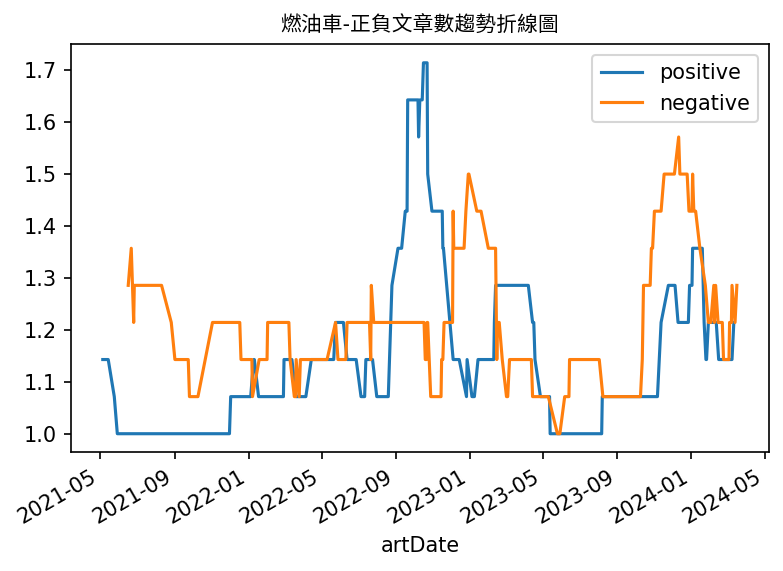

In [47]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("燃油車-正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

文章都有被歸類在正負向文章，討論燃油車的正負向情緒都有。

### 3.7 情緒代表字

In [48]:
electric_df = ptt_liwc_df[ptt_liwc_df['category'] == '電動車']
fuel_df = ptt_liwc_df[ptt_liwc_df['category'] == '燃油車']

electric_word_count = electric_df.groupby(["word", "sentiments"]).size().reset_index(name="size")
electric_word_count = electric_word_count.sort_values(["size"], ascending=False)

fuel_word_count = fuel_df.groupby(["word", "sentiments"]).size().reset_index(name="size")
fuel_word_count = fuel_word_count.sort_values(["size"], ascending=False)

print("電動車詞數:")
print(electric_word_count.head())
print("\n燃油車詞數:")
print(fuel_word_count.head())


電動車詞數:
    word sentiments  size
303   問題     affect   503
304   問題   negative   503
161   免費     affect   116
162   免費   positive   116
930   焦慮   negative   114

燃油車詞數:
    word sentiments  size
130   問題     affect    76
131   問題   negative    76
325   效率     affect    27
326   效率   positive    27
132   喜歡     affect    20


#### 電動車的

In [49]:
word_of_pos = electric_word_count.loc[(electric_word_count["sentiments"] == "positive")]
print("電動車:")
word_of_pos.head(15)

電動車:


,word,sentiments,size
162,免費,positive,116
747,效率,positive,105
143,優勢,positive,101
1278,適合,positive,99
1230,豪華,positive,92
409,安全,positive,90
1186,解決,positive,85
310,喜歡,positive,78
45,不錯,positive,72
156,優點,positive,69


In [50]:
word_of_neg = electric_word_count.loc[(electric_word_count["sentiments"] == "negative")]
print("電動車:")
word_of_neg.head(15)

電動車:


,word,sentiments,size
304,問題,negative,503
930,焦慮,negative,114
1315,降低,negative,75
715,擔心,negative,68
1110,缺點,negative,57
1388,麻煩,negative,53
57,事故,negative,51
245,反對,negative,36
39,不足,negative,34
1050,禁止,negative,32


C:\Users\user\AppData\Local\Temp\ipykernel_19524\1182424806.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\user\AppData\Local\Temp\ipykernel_19524\1182424806.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 0.98, '電動車')

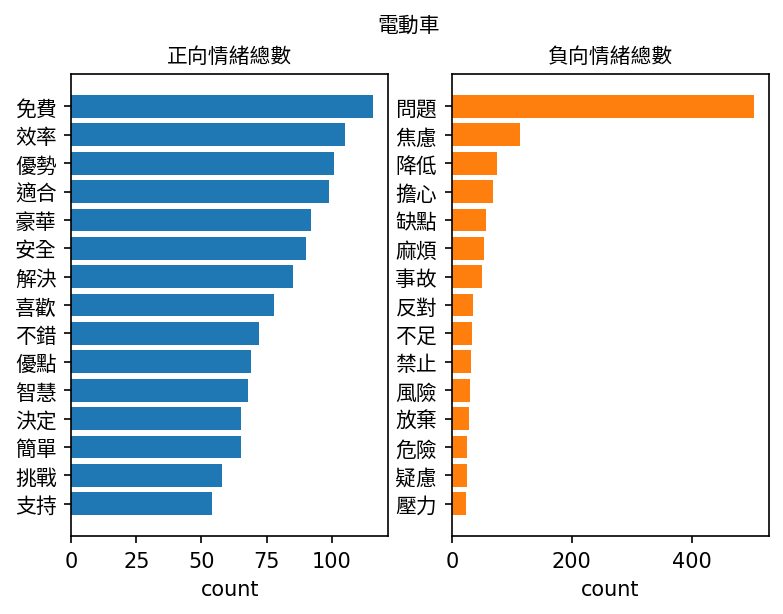

In [51]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

fig.suptitle('電動車', fontproperties=fprop)

#### 燃油車的

In [52]:
word_of_pos = fuel_word_count.loc[(fuel_word_count["sentiments"] == "positive")]
print("燃油車:")
word_of_pos.head(15)

燃油車:


,word,sentiments,size
326,效率,positive,27
133,喜歡,positive,20
16,不錯,positive,16
68,優勢,positive,15
543,豪華,positive,14
169,安靜,positive,13
567,適合,positive,11
75,優點,positive,10
474,簡單,positive,10
167,安全,positive,10


In [53]:
word_of_neg = fuel_word_count.loc[(fuel_word_count["sentiments"] == "negative")]
print("燃油車:")
word_of_neg.head(15)

燃油車:


,word,sentiments,size
131,問題,negative,76
466,禁止,negative,18
319,放棄,negative,16
413,焦慮,negative,15
581,降低,negative,13
483,缺點,negative,12
608,麻煩,negative,11
584,隨便,negative,7
149,壓力,negative,6
305,擔心,negative,6


C:\Users\user\AppData\Local\Temp\ipykernel_19524\3861797099.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\user\AppData\Local\Temp\ipykernel_19524\3861797099.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 0.98, '燃油車')

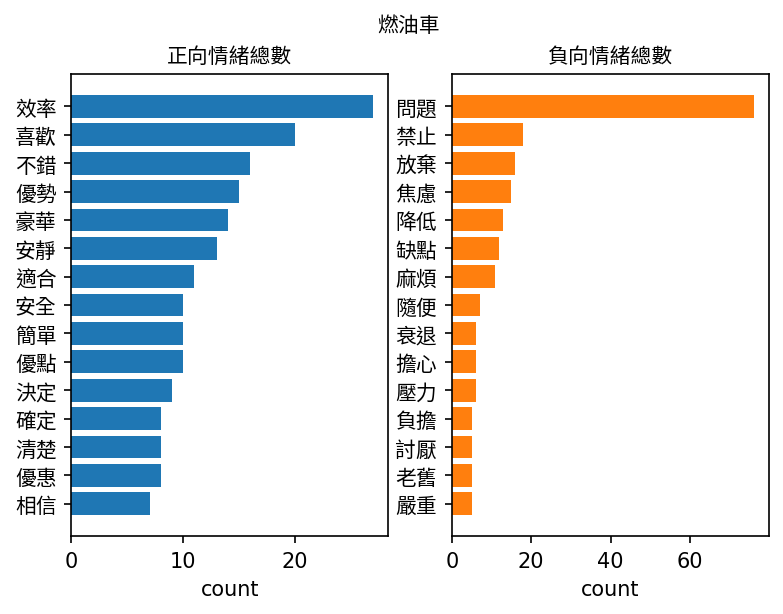

In [54]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

fig.suptitle('燃油車', fontproperties=fprop)

#### 檢查情緒詞是否符合本文本

In [55]:
#先剔除不是電動車跟油車的
sent_df = sent_df[sent_df['category'] != 'both']
filtered_df = sent_df[sent_df['sentence'].str.contains('希望', na=False)]
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence,category
410,https://www.ptt.cc/bbs/biker/M.1616782497.A.17...,[新聞]日本四大機車廠宣布電動機車換電規格,2021-03-27,Honda、Yamaha、Suzuki、Kawasaki 結盟宣布電動機車換電規格\n\n作...,不過我倒是滿希望電動機車換電聯合能來臺灣,電動車
480,https://www.ptt.cc/bbs/biker/M.1617450777.A.EE...,[新聞]台灣3月機車銷售排行出爐,2021-04-03,https://0rz.tw/4NxmS\n原文標題:【市場評論】2021年台灣機車銷售三月...,就是希望能讓民眾擁抱電動機車,電動車
1021,https://www.ptt.cc/bbs/biker/M.1618206019.A.C7...,[閒聊]入手電動車的時機,2021-04-12,其實說白了就是等待一個劃時代的產品出現\n多年前特斯拉還被一堆人認為是出來賺短線的科技玩具\...,要整合技術做他們自己的電池也許再過不久就能看到有國際水準品質的產品問世不用再局限於國內火候不...,電動車
3390,https://www.ptt.cc/bbs/biker/M.1626017119.A.E4...,[閒聊]連署電動車板,2021-07-11,各位車友好..\n\n有看到熱心板友去年曾經連署過電車板\n不過沒有連署成功\n今年加入電車...,希望創立一個電動車板提供電動車友討論,電動車
4463,https://www.ptt.cc/bbs/biker/M.1630571083.A.74...,[新聞]湛積反擊Gogoro內鬼案,2021-09-02,【全文】湛積反擊Gogoro內鬼案 林松慶：莫須有的商業打擊\n\n文/江星翰 攝影/鄒保...,我只希望台灣電動機車產業能健康發展,電動車


In [56]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

不過我倒是滿希望電動機車換電聯合能來臺灣
就是希望能讓民眾擁抱電動機車
要整合技術做他們自己的電池也許再過不久就能看到有國際水準品質的產品問世不用再局限於國內火候不足的電動車只希望到時台灣政府不要再用什麼愛國或保護國內業者等相關屁話來擋進口車
希望創立一個電動車板提供電動車友討論
我只希望台灣電動機車產業能健康發展
如果可以我希望能找到更便宜的窮苦社畜QQ最在意車牌拍的清不清楚目前油車裝響尾蛇D300但是晚上好像多少因為光源影響變化或過曝等原因不見得能拍清楚
希望能夠導入電動機車
心得真的很心動一來是家裡有需求二來是是近來補助齊發再者自己騎共享電動機車體驗很不錯EZ1雖然還沒實際騎過但順眼外型朋友良好反饋感覺應該挺棒的Po上來是希望能多聽聽板上大大們意見可能有我沒想到的點或是如果有更多實際騎乘心得分享那就再好不過我也會去跟我朋友問看看能不能讓我試騎看看如果可以再來補心得
之前有看到F1 III 的開箱看他的夜間畫面好像還不錯不知實際如何看板上有一篇討論蠻熱烈希望版友也可以分享一些經驗談主要是合電車的款式  畫面清晰穩定預算大概在6千左右再麻煩給於建議了 謝謝
我衷心希望光陽成為電動車第一大廠
有競爭才有進步GOGORO也不能因為市場夠大就不持續汱換電池或是持續漲價 漲資費等希望ionex繼續加油
 雖然我希望光陽也能加強為台灣電動車市場做出努力
實施廠辦合一希望提高溝通效率同時成立EV電動機車研發中心
希望能好好的電動機車稱下去
雖然有個前庭可以把車牽進來充電但還是希望可以單拿電池進來室內充
希望有abs不要電動車
也希望盡量轉使用低碳電動車
不管是油車還電車一下用機械式車速感應器魚目混珠電子式車速感應器一下子搞個伸縮自如的油箱真心希望可以認真加油不要再讓消費者有跳票的感覺了
感覺廠商就是十分不希望客戶去使用超充結果就是中油外都慢慢收掉改做汽車充電站
希望能藉由提高燃油車的稅收來進一步提供購買電動車的優惠補助
希望特斯拉可以盡快找出問題點
希望特斯拉也能盡快找出問題給大家一個說法
福斯希望以燃油汽車的利潤來資助電動汽車的研發生產
CAC 希望政府從電動車的公共停車空間開始著手
底下開始有人留言我希望他的福特MachE失控撞毀或是自然起火Sergio Rodriguez更收到來自自稱是特斯拉車主的私訊
台灣人才會希望燃油車禁令最好不要來
希望相隨想太多除非直接修法一律

#### 重新計算情緒

移除部分字(其實並非正負面情緒的詞彙)

In [57]:
# 設定要移除的字詞列表
words_to_remove = ['問題','降低','缺點','控制','謝謝','希望']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
#先剔除不是電動車跟油車的
noStop_df = noStop_df[noStop_df['category'] != 'both']
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word",'category']], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,category,sentiments
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,油車,電動車,NaN
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,品牌,電動車,NaN
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,偏好,電動車,affect
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,聽說,電動車,NaN
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,Gogoro,電動車,NaN


#### 先分電動車燃油車

In [58]:
electric_df = ptt_liwc_df_revise[ptt_liwc_df_revise['category'] == '電動車']
fuel_df = ptt_liwc_df_revise[ptt_liwc_df_revise['category'] == '燃油車']

##### 電動車的

C:\Users\user\AppData\Local\Temp\ipykernel_19524\3506669573.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\user\AppData\Local\Temp\ipykernel_19524\3506669573.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 0.98, '電動車')

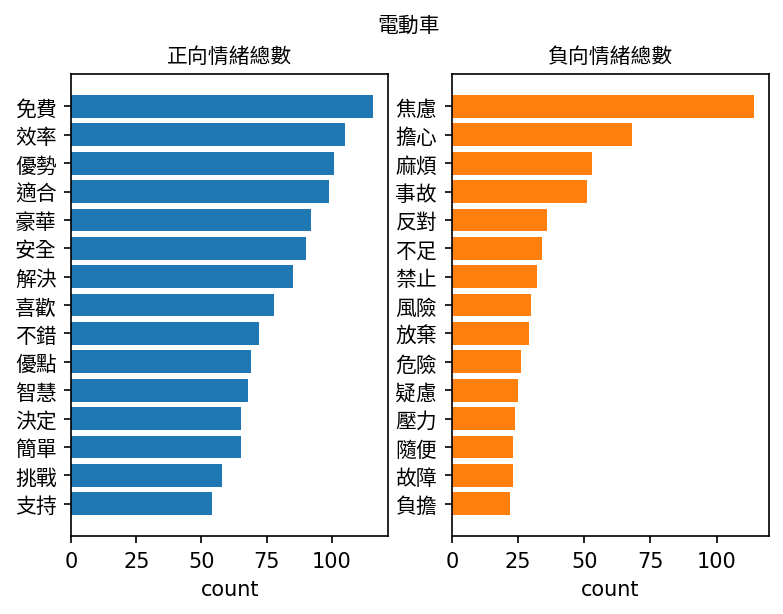

In [59]:
word_count = electric_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)
fig.suptitle('電動車', fontproperties=fprop)

##### 燃油車

C:\Users\user\AppData\Local\Temp\ipykernel_19524\127408974.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\user\AppData\Local\Temp\ipykernel_19524\127408974.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 0.98, '燃油車')

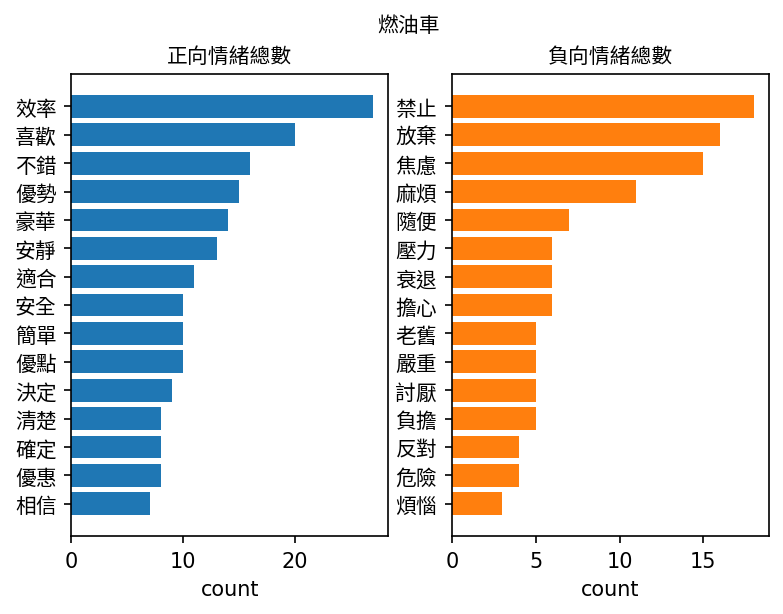

In [60]:
word_count = fuel_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)
fig.suptitle('燃油車', fontproperties=fprop)

重新繪製情緒分數趨勢圖

電動車的

Text(0.5, 1.0, '電動車-正負情緒分數趨勢折線圖')

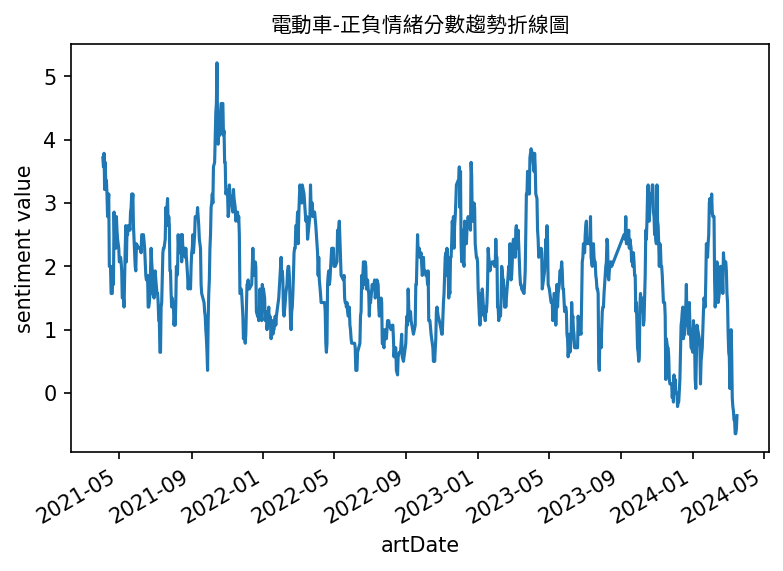

In [61]:
sentiment_count_revise = pd.DataFrame(
    electric_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("電動車-正負情緒分數趨勢折線圖", fontproperties=fprop)

燃油車的

Text(0.5, 1.0, '燃油車-正負情緒分數趨勢折線圖')

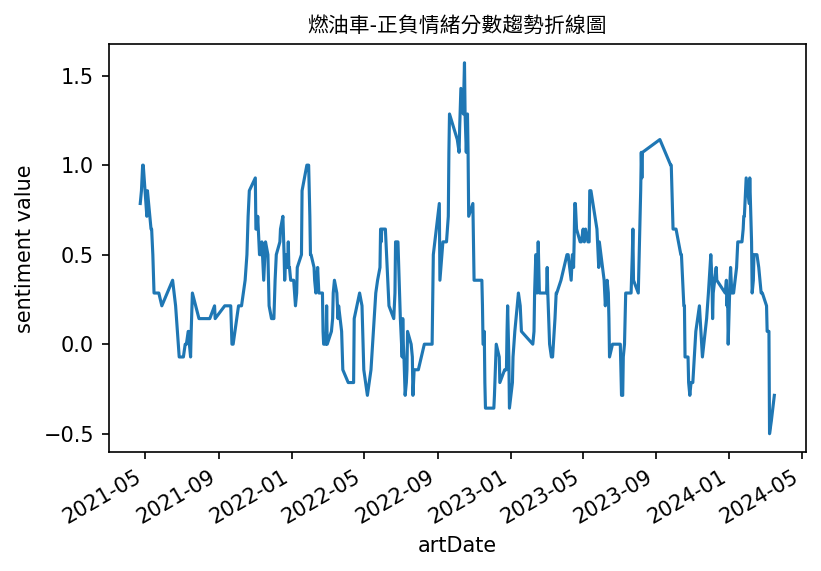

In [62]:
sentiment_count_revise = pd.DataFrame(
    fuel_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("燃油車-正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

將前面計算出的文章情緒類別合併，以利過濾出負面文章資料

#### 電動車的

In [63]:
# ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
# ptt_liwc_df_revise.head()
electric_df = pd.merge(electric_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
electric_df.head()

,artUrl,artDate,artTitle,artContent,word,category,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,油車,電動車,NaN,NaN
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,品牌,電動車,NaN,NaN
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,偏好,電動車,affect,NaN
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,聽說,電動車,NaN,NaN
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,Gogoro,電動車,NaN,NaN


In [64]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,category,sentiment_class
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,油車無品牌偏好 但聽說電動車就是要Gogoro,電動車,NaN
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,但是我真的真的很喜歡電動車的加速力跟CBS煞車試騎時只有這種,電動車,NaN
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,然後是150CC的油車 我只騎過兩三次 它一樣可以做到上陂持續加速,燃油車,NaN
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,只是沒有電動車那麼快 但是很明顯的是置物空間大不少這是我這個新手唯一真正看懂的最大差異 XDXD,電動車,NaN
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,3我把精華區新手介紹大略的看過一遍 卻沒看到電動車的介紹當然更沒有電動車跟油車的比較,電動車,NaN


In [65]:
date = "2022-05-01"
end_date = "2022-09-30"
mask = (electric_df['artDate'] >= pd.Timestamp(date).date()) & (
    electric_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    electric_df['sentiment_class'] == "負向")

ptt_df_wc = electric_df.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,category,sentiments,sentiment_class
4774,https://www.ptt.cc/bbs/biker/M.1653705289.A.C9...,2022-05-28,Re:[選購]SYMFiddleDX/宏佳騰Ai-1Ultra請益,剛好家裡有fiddle 125 跟ai-1 comfort，應該可以做一個粗略的建議。\n\...,市區,電動車,NaN,負向
4775,https://www.ptt.cc/bbs/biker/M.1653705289.A.C9...,2022-05-28,Re:[選購]SYMFiddleDX/宏佳騰Ai-1Ultra請益,剛好家裡有fiddle 125 跟ai-1 comfort，應該可以做一個粗略的建議。\n\...,用車,電動車,NaN,負向
4776,https://www.ptt.cc/bbs/biker/M.1653705289.A.C9...,2022-05-28,Re:[選購]SYMFiddleDX/宏佳騰Ai-1Ultra請益,剛好家裡有fiddle 125 跟ai-1 comfort，應該可以做一個粗略的建議。\n\...,首選,電動車,NaN,負向
4777,https://www.ptt.cc/bbs/biker/M.1653705289.A.C9...,2022-05-28,Re:[選購]SYMFiddleDX/宏佳騰Ai-1Ultra請益,剛好家裡有fiddle 125 跟ai-1 comfort，應該可以做一個粗略的建議。\n\...,電車,電動車,NaN,負向
4778,https://www.ptt.cc/bbs/biker/M.1653705289.A.C9...,2022-05-28,Re:[選購]SYMFiddleDX/宏佳騰Ai-1Ultra請益,剛好家裡有fiddle 125 跟ai-1 comfort，應該可以做一個粗略的建議。\n\...,電車,電動車,NaN,負向
...,...,...,...,...,...,...,...,...
67997,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,2022-09-11,Re:[討論]其實氫燃料電池才是未來吧,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,沒辦法,電動車,NaN,負向
67998,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,2022-09-11,Re:[討論]其實氫燃料電池才是未來吧,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,做到,電動車,NaN,負向
67999,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,2022-09-11,Re:[討論]其實氫燃料電池才是未來吧,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,氫燃料,電動車,NaN,負向
68000,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,2022-09-11,Re:[討論]其實氫燃料電池才是未來吧,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,車也,電動車,NaN,負向


In [66]:
date = "2021-05-15"
end_date = "2021-09-15"
mask = (electric_df['artDate'] >= pd.Timestamp(date).date()) & (
    electric_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    electric_df['sentiment_class'] == "負向")

ptt_df_wc = electric_df.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
111,充電,27
497,電池,14
98,保護,8
160,喜歡,8
270,日本,7
...,...,...
194,小時,1
193,小弟,1
192,小孩,1
191,對齊,1


(-0.5, 399.5, 199.5, -0.5)

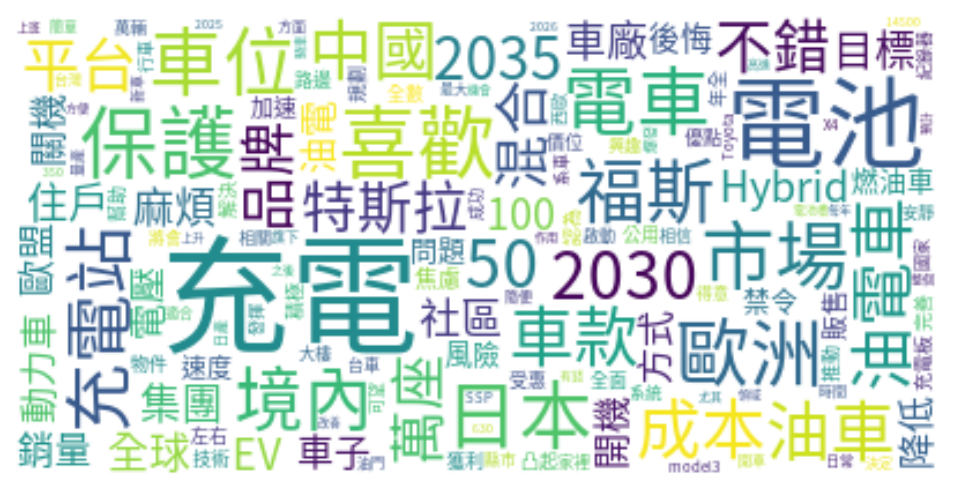

In [67]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

#### 燃油車的

In [68]:
# ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
# ptt_liwc_df_revise.head()
fuel_df = pd.merge(fuel_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
fuel_df.head()

,artUrl,artDate,artTitle,artContent,word,category,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,150CC,燃油車,NaN,NaN
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,油車,燃油車,NaN,NaN
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,騎過,燃油車,NaN,NaN
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,兩三次,燃油車,NaN,NaN
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,2021-03-17,[新車]該買150CCABS油車還是125CCABS電動車?,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,做到,燃油車,NaN,NaN


In [69]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,category,sentiment_class
0,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,油車無品牌偏好 但聽說電動車就是要Gogoro,電動車,NaN
1,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,但是我真的真的很喜歡電動車的加速力跟CBS煞車試騎時只有這種,電動車,NaN
2,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,然後是150CC的油車 我只騎過兩三次 它一樣可以做到上陂持續加速,燃油車,NaN
3,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,只是沒有電動車那麼快 但是很明顯的是置物空間大不少這是我這個新手唯一真正看懂的最大差異 XDXD,電動車,NaN
4,https://www.ptt.cc/bbs/biker/M.1615970840.A.05...,[新車]該買150CCABS油車還是125CCABS電動車?,2021-03-17,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\n\n 沒看見2021主流車種...,3我把精華區新手介紹大略的看過一遍 卻沒看到電動車的介紹當然更沒有電動車跟油車的比較,電動車,NaN


In [70]:
date = "2021-05-15"
end_date = "2021-09-15"
mask = (fuel_df['artDate'] >= pd.Timestamp(date).date()) & (
    fuel_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    fuel_df['sentiment_class'] == "負向")

ptt_df_wc = fuel_df.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,category,sentiments,sentiment_class
454,https://www.ptt.cc/bbs/biker/M.1623857981.A.79...,2021-06-16,Re:[閒聊]PGO的新車是燃油車款,"看來本板對市場還有點誤會,分享一下見聞\n文末來個1000P幣有獎徵答\nPGO應該沒說過要...",見聞,燃油車,NaN,負向
455,https://www.ptt.cc/bbs/biker/M.1623857981.A.79...,2021-06-16,Re:[閒聊]PGO的新車是燃油車款,"看來本板對市場還有點誤會,分享一下見聞\n文末來個1000P幣有獎徵答\nPGO應該沒說過要...",文末,燃油車,NaN,負向
456,https://www.ptt.cc/bbs/biker/M.1623857981.A.79...,2021-06-16,Re:[閒聊]PGO的新車是燃油車款,"看來本板對市場還有點誤會,分享一下見聞\n文末來個1000P幣有獎徵答\nPGO應該沒說過要...",來個,燃油車,NaN,負向
457,https://www.ptt.cc/bbs/biker/M.1623857981.A.79...,2021-06-16,Re:[閒聊]PGO的新車是燃油車款,"看來本板對市場還有點誤會,分享一下見聞\n文末來個1000P幣有獎徵答\nPGO應該沒說過要...",1000P,燃油車,NaN,負向
458,https://www.ptt.cc/bbs/biker/M.1623857981.A.79...,2021-06-16,Re:[閒聊]PGO的新車是燃油車款,"看來本板對市場還有點誤會,分享一下見聞\n文末來個1000P幣有獎徵答\nPGO應該沒說過要...",有獎徵答,燃油車,NaN,負向
...,...,...,...,...,...,...,...,...
5804,https://www.ptt.cc/bbs/car/M.1629947950.A.14C....,2021-08-26,[問題]驗車的時候開啟節能模式或動力模式有差？,現在有些高級車款或跑車有一些動力模式可以選，引擎、排氣聲浪和變速箱邏輯可以根據\n選擇的模式...,作弊,燃油車,affect,負向
5805,https://www.ptt.cc/bbs/car/M.1629947950.A.14C....,2021-08-26,[問題]驗車的時候開啟節能模式或動力模式有差？,現在有些高級車款或跑車有一些動力模式可以選，引擎、排氣聲浪和變速箱邏輯可以根據\n選擇的模式...,作弊,燃油車,negative,負向
5806,https://www.ptt.cc/bbs/car/M.1629947950.A.14C....,2021-08-26,[問題]驗車的時候開啟節能模式或動力模式有差？,現在有些高級車款或跑車有一些動力模式可以選，引擎、排氣聲浪和變速箱邏輯可以根據\n選擇的模式...,作弊,燃油車,anger,負向
5807,https://www.ptt.cc/bbs/car/M.1629947950.A.14C....,2021-08-26,[問題]驗車的時候開啟節能模式或動力模式有差？,現在有些高級車款或跑車有一些動力模式可以選，引擎、排氣聲浪和變速箱邏輯可以根據\n選擇的模式...,醜聞,燃油車,NaN,負向


In [71]:
date = "2021-05-15"
end_date = "2021-09-15"
mask = (fuel_df['artDate'] >= pd.Timestamp(date).date()) & (
    fuel_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    fuel_df['sentiment_class'] == "負向")

ptt_df_wc = fuel_df.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
201,油車,20
215,燃油車,18
228,禁售,11
214,燃油,10
213,煩惱,10
...,...,...
165,方案,1
166,旅程,1
167,既有,1
46,仍以,1


(-0.5, 399.5, 199.5, -0.5)

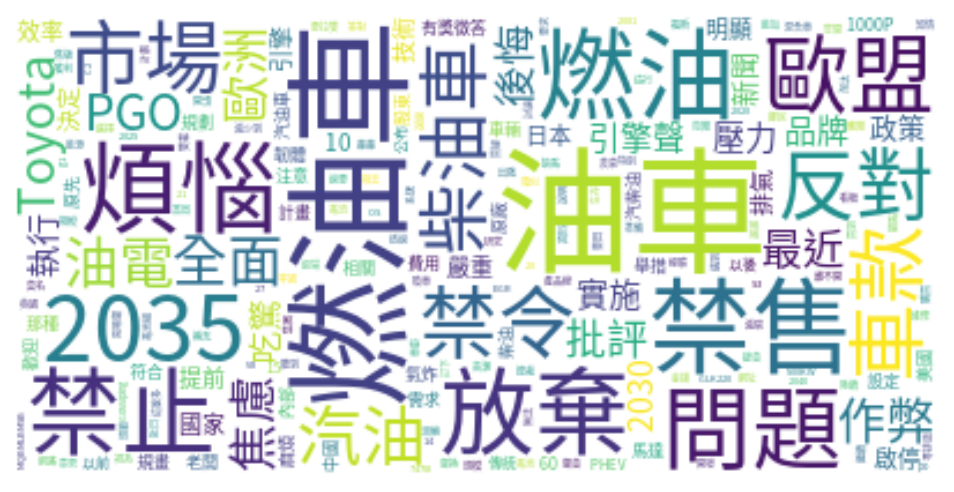

In [72]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

# 我們的發現

我們透過前面的圖表發現電動車在2023/11~2024/03以及2022/05~2022/09之間負向情緒較多，因此抓這兩個時間段的文章出來觀察，可以發現說當時候電動的的充電及門把手設計問題被廣泛討論。

In [73]:
date = "2023-11-30"
end_date = "2024-03-16"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('電動車')) & (
    sent_df['sentence'].str.contains('充電')) # 包含「缺點」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,category,sentiment_class
19957,https://www.ptt.cc/bbs/car/M.1702442269.A.B4E....,[情報]特斯拉車主分享各種頭痛問題,2023-12-13,居然會有這麼多人花的下兩百多萬甚至四五百萬以上買這樣的電動豪車\n感覺真的很神奇\n\n==...,一位 Model S 車主就針對這一問題對特斯拉提起集體訴訟,電動車,負向
19958,https://www.ptt.cc/bbs/car/M.1702442269.A.B4E....,[情報]特斯拉車主分享各種頭痛問題,2023-12-13,居然會有這麼多人花的下兩百多萬甚至四五百萬以上買這樣的電動豪車\n感覺真的很神奇\n\n==...,稱特斯拉壟斷其車輛維修市場,電動車,負向
19959,https://www.ptt.cc/bbs/car/M.1702442269.A.B4E....,[情報]特斯拉車主分享各種頭痛問題,2023-12-13,居然會有這麼多人花的下兩百多萬甚至四五百萬以上買這樣的電動豪車\n感覺真的很神奇\n\n==...,特斯拉門把手設計不良,電動車,負向
19960,https://www.ptt.cc/bbs/car/M.1702442269.A.B4E....,[情報]特斯拉車主分享各種頭痛問題,2023-12-13,居然會有這麼多人花的下兩百多萬甚至四五百萬以上買這樣的電動豪車\n感覺真的很神奇\n\n==...,一些特斯拉車主表示,電動車,負向
19961,https://www.ptt.cc/bbs/car/M.1702442269.A.B4E....,[情報]特斯拉車主分享各種頭痛問題,2023-12-13,居然會有這麼多人花的下兩百多萬甚至四五百萬以上買這樣的電動豪車\n感覺真的很神奇\n\n==...,特斯拉的門把手問題很多,電動車,負向
...,...,...,...,...,...,...,...
22219,https://www.ptt.cc/bbs/car/M.1709870269.A.679....,Re:[電車]電車有里程焦慮？,2024-03-08,其實從另一面來看\n\n如果今天有人去說開“油車“的人會有里程焦慮怎麼辦？\n\n會有油車主...,電動車本來就有缺陷這是事實,電動車,負向
22220,https://www.ptt.cc/bbs/car/M.1709870318.A.2D1....,[討論]n7沒預定的人什麼時候才能試乘？,2024-03-08,我可能會買n7吧 1百萬出頭的suv電動車 價格很吸引人 內裝寬敞 而且沒有油車的噪音 行\...,我可能會買n7吧 1百萬出頭的suv電動車 價格很吸引人 內裝寬敞 而且沒有油車的噪音 行駛...,電動車,NaN
22221,https://www.ptt.cc/bbs/car/M.1709872984.A.09D....,Re:[電車]電車有里程焦慮？,2024-03-08,你住在宜花東的話電車就很焦慮了，宜花東住\n\n非透天的也不少，目前超充站一個鄉鎮還沒有\n...,你住在宜花東的話電車就很焦慮了,電動車,NaN
22222,https://www.ptt.cc/bbs/car/M.1709872984.A.09D....,Re:[電車]電車有里程焦慮？,2024-03-08,你住在宜花東的話電車就很焦慮了，宜花東住\n\n非透天的也不少，目前超充站一個鄉鎮還沒有\n...,而且住透天的裝充電樁意願也不高,電動車,NaN


In [74]:
date = "2022-05-01"
end_date = "2022-09-20"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('電動車')) & (
    sent_df['sentence'].str.contains('充電')) # 包含「缺點」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,category,sentiment_class
9590,https://www.ptt.cc/bbs/car/M.1654839115.A.097....,Re:[問題]最近吵很兇的電車,2022-06-10,電車光在那邊找快充站我就飽了...人生最珍貴的還是時間! 真的很討厭開車在那邊\n 找目標...,現在開電動車就大概酷炫而已,電動車,負向
9591,https://www.ptt.cc/bbs/car/M.1654839115.A.097....,Re:[問題]最近吵很兇的電車,2022-06-10,電車光在那邊找快充站我就飽了...人生最珍貴的還是時間! 真的很討厭開車在那邊\n 找目標...,油車也都可以沒啥吸引力,燃油車,負向
9592,https://www.ptt.cc/bbs/car/M.1654839115.A.097....,Re:[問題]最近吵很兇的電車,2022-06-10,電車光在那邊找快充站我就飽了...人生最珍貴的還是時間! 真的很討厭開車在那邊\n 找目標...,畢竟加油站太容易找了 要我浪費時間找快充,燃油車,負向
9593,https://www.ptt.cc/bbs/car/M.1654839115.A.097....,Re:[問題]最近吵很兇的電車,2022-06-10,電車光在那邊找快充站我就飽了...人生最珍貴的還是時間! 真的很討厭開車在那邊\n 找目標...,靠我去加油站等太久都覺得煩躁了 真的算了快充10分鐘對我來說也是浪費時間的事情,燃油車,負向
9594,https://www.ptt.cc/bbs/car/M.1654839115.A.097....,Re:[問題]最近吵很兇的電車,2022-06-10,電車光在那邊找快充站我就飽了...人生最珍貴的還是時間! 真的很討厭開車在那邊\n 找目標...,開電車對我這種來說是活受罪,電動車,負向
...,...,...,...,...,...,...,...
10856,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,Re:[討論]其實氫燃料電池才是未來吧,2022-09-11,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,跟汽油車其實沒有比較環保啊這個是總體的經濟跟環保的問題,燃油車,負向
10857,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,Re:[討論]其實氫燃料電池才是未來吧,2022-09-11,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,現在的氫燃料太貴了跑同樣的距離 燃料比汽油貴更是電動車的8倍左右 補助更不可能這樣大撒幣,電動車,負向
10858,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,Re:[討論]其實氫燃料電池才是未來吧,2022-09-11,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,電動車可以做到家充快充,電動車,負向
10859,https://www.ptt.cc/bbs/car/M.1662900919.A.FCA....,Re:[討論]其實氫燃料電池才是未來吧,2022-09-11,氫燃料絕對不是未來\n\n\n最大的問題，第一就是效率\n如果要做到真的環保，氫的來源如果是...,到處都有但氫燃料站卻沒辦法做到結果氫燃料車也不會比電動車方便,電動車,負向
